In [ ]:
#5 3 2020 to 11 8 2024

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from random import randrange

In [2]:
df=pd.read_csv("sector_51_daily_aqi.csv")

In [3]:
df.tail()

,Date,AQI
515,07-08-2024,70.0
516,08-08-2024,95.0
517,09-08-2024,109.0
518,10-08-2024,125.0
519,11-08-2024,98.0


In [4]:
df.head()

,Date,AQI
0,11-03-2023,312.0
1,12-03-2023,312.0
2,13-03-2023,315.0
3,14-03-2023,306.0
4,15-03-2023,318.0


In [5]:
df.shape

(520, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    520 non-null    object 
 1   AQI     518 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.3+ KB


In [7]:
df.describe()

,AQI
count,518.000000
mean,210.972973
std,92.900850
min,37.000000
25%,151.000000
50%,197.000000
75%,274.500000
max,663.000000


In [8]:
df.describe(include = 'object')

,Date
count,520
unique,520
top,11-03-2023
freq,1


In [9]:
df.isnull().sum()

Date    0
AQI     2
dtype: int64

There were two null values in the dataset which has been filled with the linear interpolation

In [10]:
df = df.interpolate(method='linear')

In [11]:
df.isnull().sum()

Date    0
AQI     0
dtype: int64

2 Data Visualization and Interpretations

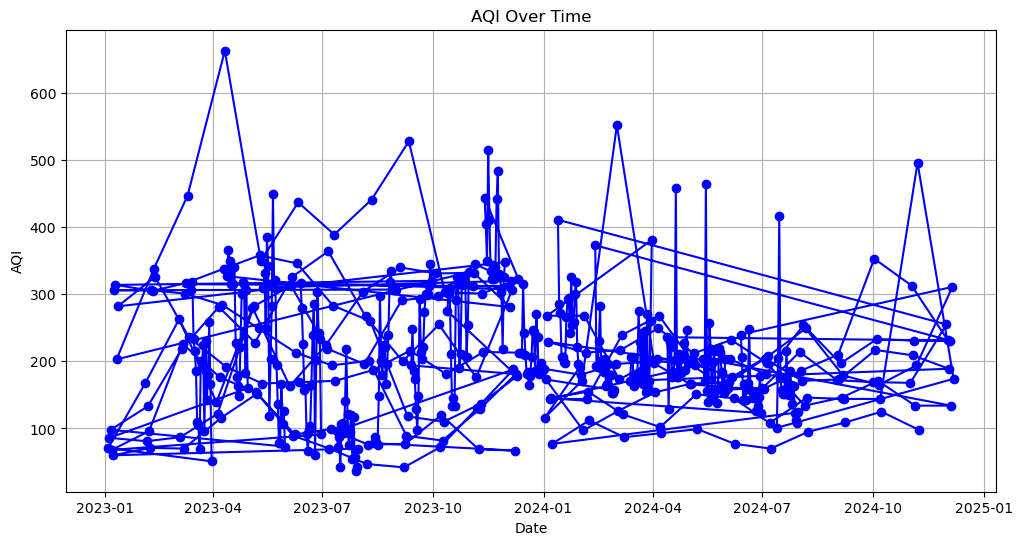

In [12]:
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Plot the 'AQI' column
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AQI'], marker='o', linestyle='-', color='b')
plt.title('AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.show()

To transform the discrete data into a continuous format, two options are available:
1) Log transformation: This method not only converts the data into a continuous form but also scales it to a more manageable range.
2) Adding a number between 0 and 1 from a uniform distribution: This approach introduces randomness to the data while maintaining continuity, thereby ensuring a smooth transition from discrete to continuous representation.


In [13]:
print(df.columns)


Index(['AQI'], dtype='object')


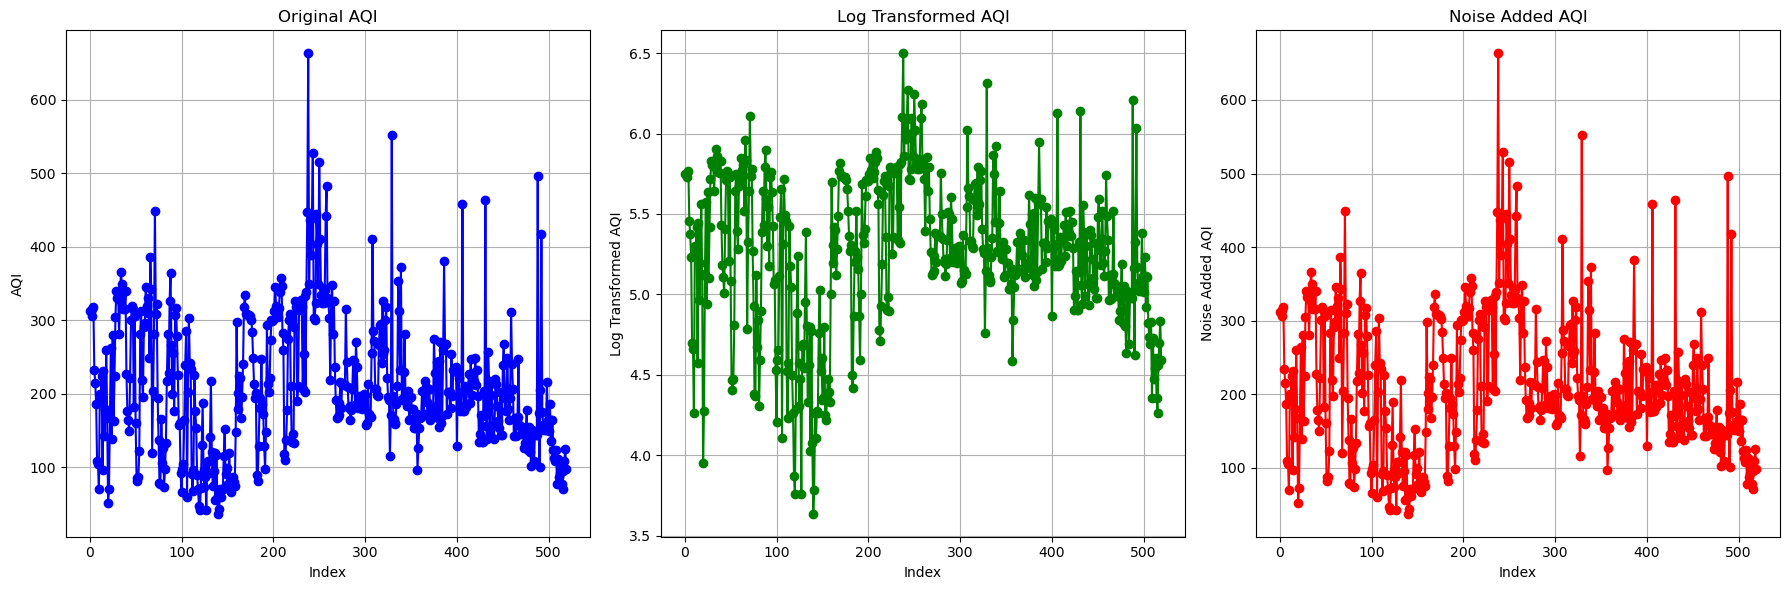

In [14]:

# Apply transformations
df['Log_Transformed_AQI'] = np.log1p(df['AQI'])
df['Noise_Transformed_AQI'] = df['AQI'] + np.random.uniform(0, 1, size=len(df))

# Create indices for plotting
df['Index'] = range(len(df))

# Plotting
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.plot(df['Index'], df['AQI'], marker='o', linestyle='-', color='b')
plt.title('Original AQI')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.grid(True)

# Plot log-transformed data
plt.subplot(1, 3, 2)
plt.plot(df['Index'], df['Log_Transformed_AQI'], marker='o', linestyle='-', color='g')
plt.title('Log Transformed AQI')
plt.xlabel('Index')
plt.ylabel('Log Transformed AQI')
plt.grid(True)

# Plot data with added uniform noise
plt.subplot(1, 3, 3)
plt.plot(df['Index'], df['Noise_Transformed_AQI'], marker='o', linestyle='-', color='r')
plt.title('Noise Added AQI')
plt.xlabel('Index')
plt.ylabel('Noise Added AQI')
plt.grid(True)

plt.tight_layout()
plt.show()

#Log AQI Series plot:

#AQI + U(0,1) Series plot:

The log transformation has effectively compressed the range of the series, resulting in a more manageable and scaled representation of the data. The uniform transformed series appears to maintain its original characteristics, showing no discernible change. 
The series plots reveal a dynamic pattern where the mean and variance exhibit fluctuations over time, indicating a departure from stationarity, which will be thoroughly examined in the next section.
To validate a time series model, the dataset is typically divided into two parts: one for training and another for testing. In this context, the Air Quality Index (AQI) data for the last ##### 42 days is used for the testing set.


In [15]:
# Split data into Train & Test
split_date = '2024-05-01'
ts_train = daily_df[daily_df.index <= split_date]
ts_test = daily_df[daily_df.index > split_date]


NameError: name 'daily_df' is not defined

In [16]:
split_date

'2024-05-01'

3- Examining Stationarity 

For Log transformed series,ACF Plot – 

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df['Log_Transformed_AQI'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -4.221492890672147
p-value: 0.0006058244920111277
Critical Values: {'1%': -3.443136494643789, '5%': -2.8671794725841147, '10%': -2.5697736283668187}


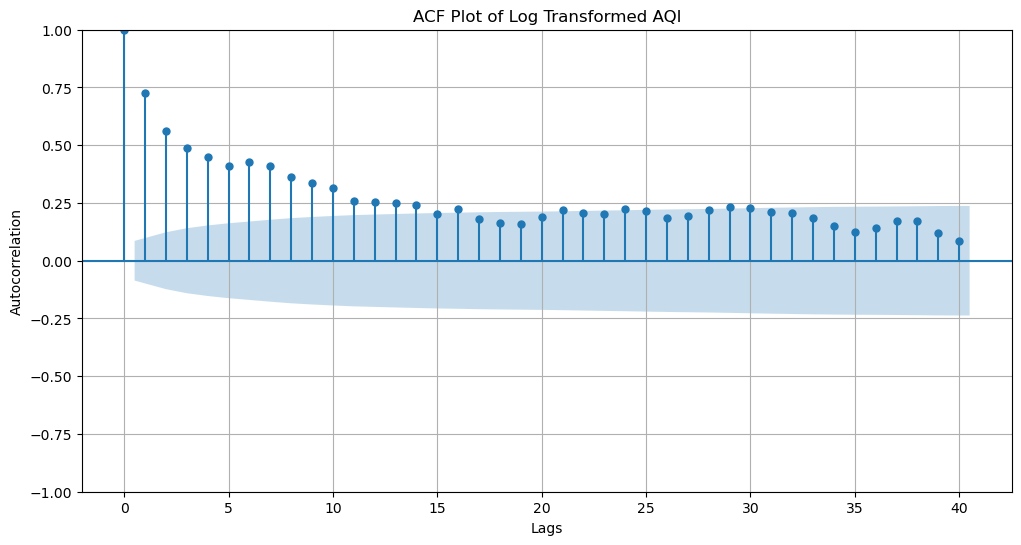

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the log-transformed series
plt.figure(figsize=(12, 6))
plot_acf(df['Log_Transformed_AQI'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF Plot of Log Transformed AQI')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


•	The autocorrelation function (ACF) displays a slow decay, indicating the presence of a unit root and thus non-stationarity.
•	Additionally, prominent spikes are evident at lags 7, 14, and 21, implying the existence of seasonality with a weekly period of 7 days. Addressing this seasonality will be a key focus during the identification of SARIMA models.


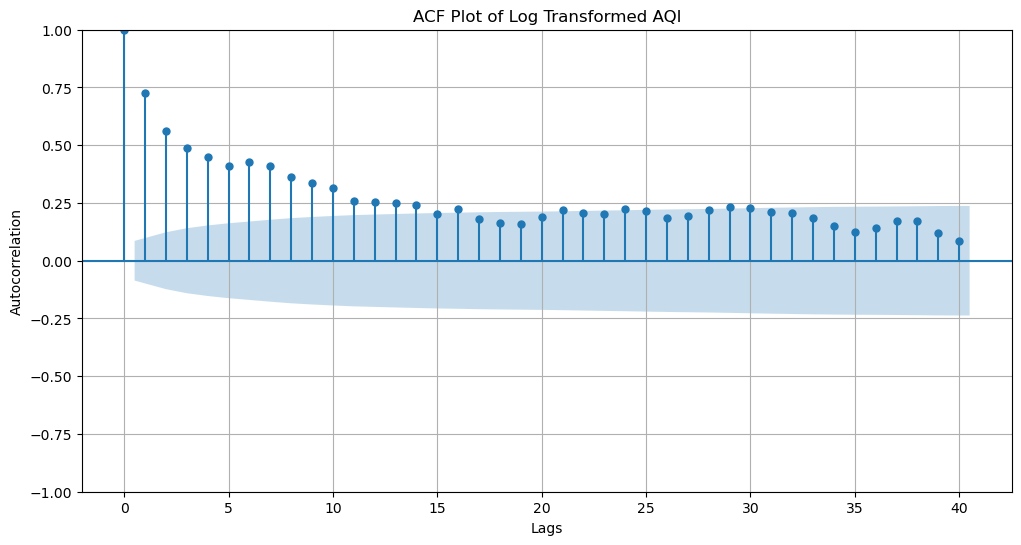

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the log-transformed series
plt.figure(figsize=(12, 6))
plot_acf(df['Log_Transformed_AQI'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF Plot of Log Transformed AQI')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Compute ACF values with confidence intervals
acf_results = acf(df['Log_Transformed_AQI'].dropna(), nlags=40, fft=True, alpha=0.05)

# Extract ACF values and confidence intervals
acf_values = acf_results[0]  # ACF values
confint = acf_results[1]    # Confidence intervals

# Create a DataFrame to display the results
acf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'Lower CI': confint[:, 0],  # Lower bound of confidence interval
    'Upper CI': confint[:, 1]   # Upper bound of confidence interval
})

# Print prominent spikes (adjust threshold as needed)
print(acf_df[acf_df['ACF'].abs() > 0.2])


    Lag       ACF  Lower CI  Upper CI
0     0  1.000000  1.000000  1.000000
1     1  0.724833  0.638883  0.810783
2     2  0.560566  0.437481  0.683651
3     3  0.488850  0.348163  0.629536
4     4  0.449933  0.297213  0.602653
5     5  0.410422  0.248205  0.572640
6     6  0.426494  0.256779  0.596209
7     7  0.409949  0.232493  0.587405
8     8  0.361073  0.176753  0.545393
9     9  0.335225  0.145752  0.524698
10   10  0.313440  0.119635  0.507245
11   11  0.257712  0.060198  0.455227
12   12  0.252943  0.052960  0.452926
13   13  0.249521  0.047189  0.451854
14   14  0.239083  0.034490  0.443677
15   15  0.203137 -0.003510  0.409783
16   16  0.222111  0.013994  0.430228
21   21  0.218712  0.004608  0.432816
22   22  0.208514 -0.007235  0.424262
23   23  0.201165 -0.016067  0.418397
24   24  0.225638  0.007034  0.444242
25   25  0.213273 -0.007044  0.433591
28   28  0.219933 -0.004273  0.444140
29   29  0.232772  0.006978  0.458567
30   30  0.226461 -0.001099  0.454022
31   31  0.2

Plot ACF with Confidence Intervals

<Figure size 1200x600 with 0 Axes>

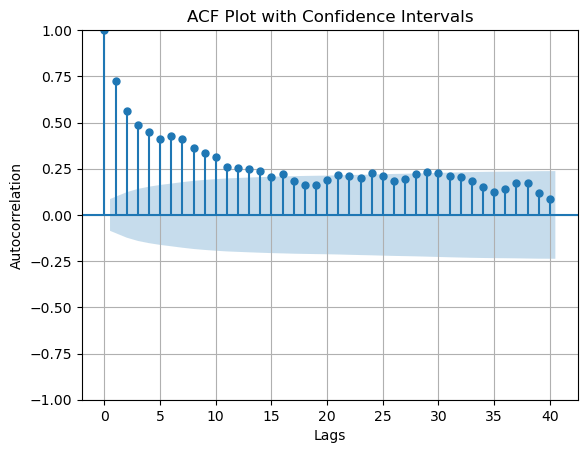

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF with confidence intervals
plt.figure(figsize=(12, 6))
plot_acf(df['Log_Transformed_AQI'].dropna(), lags=40, alpha=0.05)
plt.title('ACF Plot with Confidence Intervals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [24]:
# Split data into Train & Test in order matter
split_date = '2018-05-3'
ts_train =df[df.index <= split_date]
ts_test = df[df.index > split_date]

In [ ]:
plot_acf(ts_train,alpha=0.05,lags=15)
plt.axhline(y=0,linestyle='--',color='red')
plt.show()